In [47]:
import numpy as np
import pandas as pd
from datetime import datetime
from multiprocessing import Pool
import subprocess, shlex

from Bio import SeqIO
import requests
from io import StringIO as sio
from io import StringIO
from collections import defaultdict

import dendropy
import itertools
from tqdm.notebook import trange, tqdm

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex
from matplotlib.transforms import ScaledTranslation
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend import Legend

import src.baltic as bt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['font.sans-serif'] = ['Arial']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [48]:
# isl info
isl_info = pd.read_csv('isl_info_h5.csv', sep='\t', keep_default_na=False)
# seg info
seq_info = pd.read_csv('seg_info_h5.csv', sep='\t', keep_default_na=False)
seg2isl = seq_info.set_index('Segment_Id')['Isolate_Id'].to_dict()

all_aiv_metainfo_file = ['1.gisaid_epiflu_isolates.xls', '2.gisaid_epiflu_isolates.xls','3.gisaid_epiflu_isolates.xls']
all_aiv_metainfo = pd.concat([pd.read_excel(f'./data/all_aiv2/{l}') for l in all_aiv_metainfo_file], ignore_index=True).set_index('Isolate_Id')
# all_aiv_metainfo = all_aiv_metainfo[['Isolate_Name', 'Subtype', 'Location', 'Host', 'Collection_Date', 'Submission_Date', 'Domestic_Status']]

seg_names = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'NS', 'MP']

isl_info.shape, seq_info.shape

((3781, 26), (34760, 16))

In [49]:
isl2subtype = all_aiv_metainfo['Subtype'].str.lstrip('A / ').to_dict()

In [50]:
n1_set = isl_info.query('subtype == "H5N1"')
n1_set.head()

,Isolate_Id,HA,MP,NA,NP,NS,PA,PB1,PB2,Isolate_Name,...,Submitting_Lab,Authors,subtype,date,host,region,country,province,city,wave
992,EPI_ISL_603135,EPI1807259,EPI1807254,EPI1807258,EPI1807252,EPI1807253,EPI1807255,EPI1807257,EPI1807256,A/Eurasian Wigeon/Netherlands/5/2020,...,Erasmus Medical Center,,H5N1,2020-10-16,Eurasian Wigeon,Europe,Netherlands,,,20/21 Wave
999,EPI_ISL_603133,EPI1807243,EPI1807238,EPI1807242,EPI1807236,EPI1807237,EPI1807239,EPI1807241,EPI1807240,A/Eurasian Wigeon/Netherlands/1/2020,...,Erasmus Medical Center,,H5N1,2020-10-16,Eurasian Wigeon,Europe,Netherlands,,,20/21 Wave
1000,EPI_ISL_603134,EPI1807251,EPI1807246,EPI1807250,EPI1807244,EPI1807245,EPI1807247,EPI1807249,EPI1807248,A/Eurasian Wigeon/Netherlands/4/2020,...,Erasmus Medical Center,,H5N1,2020-10-16,Eurasian Wigeon,Europe,Netherlands,,,20/21 Wave
1040,EPI_ISL_632314,EPI1812367,EPI1812370,EPI1812369,EPI1812368,EPI1812371,EPI1812366,EPI1812365,EPI1812364,A/greylag goose/Netherlands/20016582-004/2020,...,Wageningen Bioveterinary Research,"Beerens, Nancy; Harders, Frank; Verschuren-Pri...",H5N1,2020-10-28,greylag goose,Europe,Netherlands,Provincie Noord-Holland,Gemeente Purmerend,20/21 Wave
1060,EPI_ISL_632316,EPI1812383,EPI1812386,EPI1812385,EPI1812384,EPI1812387,EPI1812382,EPI1812381,EPI1812380,A/eurasian curlew/Netherlands/20016890-001/2020,...,Wageningen Bioveterinary Research,"Beerens, Nancy; Harders, Frank; Verschuren-Pri...",H5N1,2020-11-01,eurasian curlew,Europe,Netherlands,Provincie Friesland,Hallum,20/21 Wave


# retrive strains using blastn and merge with n1-set

In [107]:
tmp = pd.read_excel('./data/02_h5n1_blast/H5N1-EPI-230303.xlsx', sheet_name='HA')
tmp = tmp['REF'].dropna().to_list()
tmp = list(set(tmp))
tmp

['EPI_ISL_1046889',
 'EPI_ISL_2932683',
 'EPI_ISL_5098135',
 'EPI_ISL_644129',
 'EPI_ISL_614401',
 'EPI_ISL_739692',
 'EPI_ISL_775267',
 'EPI_ISL_5142961',
 'EPI_ISL_7598788',
 'EPI_ISL_739690',
 'EPI_ISL_14836079',
 'EPI_ISL_775251',
 'EPI_ISL_2932682',
 'EPI_ISL_5058090',
 'EPI_ISL_1114735',
 'EPI_ISL_739685',
 'EPI_ISL_984694',
 'EPI_ISL_1139047',
 'EPI_ISL_2932609',
 'EPI_ISL_637098',
 'EPI_ISL_644138',
 'EPI_ISL_2932612',
 'EPI_ISL_739691',
 'EPI_ISL_984688',
 'EPI_ISL_2932617',
 'EPI_ISL_654838']

In [108]:
strain = all_aiv_metainfo.loc[tmp, ['Isolate_Name', 'Subtype']]
acc_seg = all_aiv_metainfo.loc[tmp, f'{seg} Segment_Id'].map(lambda x: x.split('|', 1)[0]).to_list()
strain

,Isolate_Name,Subtype
Isolate_Id,,
EPI_ISL_1046889,A/chicken/Netherlands/21023815-001005/2021,A / H5N8
EPI_ISL_2932683,A/chicken/Kazakhstan/1-20-B-Talg-67/2020,A / H5N8
EPI_ISL_5098135,A/kestrel/Germany-NI/AI03672/2020,A / H5N8
EPI_ISL_644129,A/goose/Omsk/0115/2020,A / H5N8
EPI_ISL_614401,A/mute_swan/Kazakhstan/1-267-20-B/2020,A / H5N8
EPI_ISL_739692,A/chicken/Russia_Novosibirsk region/3-29/2020,A / H5N8
EPI_ISL_775267,A/turkey/Netherlands/21020942-001005/2021,A / H5N8
EPI_ISL_5142961,A/turkey/Germany-MV/AI02458/2021,A / H5N8
EPI_ISL_7598788,A/Anser_brachyrhynchus/Belgium/13275_0009/2020,A / H5N8


In [109]:
acc_l = ','.join(acc_seg)
cmd = f'blastdbcmd -db ./data/all_aiv2/aivdb -entry {acc_l} -outfmt ">%f"'
args = shlex.split(cmd)
p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})

with StringIO() as handle:
    handle.write(p.stdout.decode('utf-8'))
    handle.seek(0)
    records = list(SeqIO.parse(handle, 'fasta'))


In [110]:
len(records)

26

In [111]:
seg_names = ['PB2', 'PA', 'NP', 'NS']

In [112]:
for seg in seg_names:
    tmp = pd.read_excel('./data/02_h5n1_blast/H5N1-EPI-230303.xlsx', sheet_name=seg)
    tmp = tmp['REF'].dropna().to_list()
    tmp = list(set(tmp))

    strain = all_aiv_metainfo.loc[tmp, 'Isolate_Name']
    acc_seg = all_aiv_metainfo.loc[tmp, f'{seg} Segment_Id'].map(lambda x: x.split('|', 1)[0]).to_list()

    # extract blast sequences for aivdb
    acc_l = ','.join(acc_seg)
    cmd = f'blastdbcmd -db ./data/all_aiv2/aivdb -entry {acc_l} -outfmt ">%f"'
    args = shlex.split(cmd)
    p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})

    with StringIO() as handle:
        handle.write(p.stdout.decode('utf-8'))
        handle.seek(0)
        records = list(SeqIO.parse(handle, 'fasta'))

        
    tmp = seq_info[seq_info.Segment_Id.isin(n1_set[seg])]
    f = open(f'./data/02_h5n1_blast/extend_{seg}.fasta', 'w')
    f2 = open(f'./data/02_h5n1_blast/date_{seg}.txt', 'w')
    f3 = open(f'./data/02_h5n1_blast/meta_{seg}.txt', 'w')
    f2.write('Name,Date,Region,Strain\n')
    f3.write('Name\tDate\tRegion\tCountry\tStrain\tSubtype\n')
    
    for _, (isl_acc, isl_name, seg_acc, seq) in tmp[['Isolate_Id', 'Isolate_Name', 'Segment_Id', 'Sequence']].iterrows():
        date = n1_set.loc[n1_set.Isolate_Id==isl_acc, 'date'].values[0]
        date = bt.decimalDate(date, fmt='%Y-%m-%d')
        region = n1_set.loc[n1_set.Isolate_Id==isl_acc, 'Location'].values[0].split(' / ')[0]
        country = n1_set.loc[n1_set.Isolate_Id==isl_acc, 'Location'].values[0].split(' / ')[1]
        subtype='H5N1'
        f.write(f'>{isl_acc}\n{seq}\n')
        f2.write(f'{isl_acc},{date},{region},{isl_name} {subtype}\n')
        f3.write(f'{isl_acc}\t{date}\t{region}\t{country}\t{isl_name} {subtype}\t{subtype}\n')

    for record in records:
        seg_acc, des = record.description.split(' ', 1)
        isl_acc, isl_name, _, date, _, subtype = des.split('|')
        date = bt.decimalDate(date, fmt='%Y-%m-%d')
        region = all_aiv_metainfo.loc[isl_acc, 'Location'].split(' / ')[0]
        country = all_aiv_metainfo.loc[isl_acc, 'Location'].split(' / ')[1]
        subtype = subtype.replace('A_/_','')
        f.write(f'>{isl_acc}\n{str(record.seq.lower())}\n')
        f2.write(f'{isl_acc},{date},{region},{isl_name} {subtype}\n')
        f3.write(f'{isl_acc}\t{date}\t{region}\t{country}\t{isl_name} {subtype}\t{subtype}\n')

    f.close()
    f2.close()
    f3.close()

## align using mafft

In [113]:
def align_to_ref(seg):
    cmd = f'mafft --anysymbol --auto ./data/02_h5n1_blast/extend_{seg}.fasta > ./data/02_h5n1_blast/extend_{seg}.align.fasta'
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return p


with Pool(4) as pool:
    pool.map(align_to_ref, seg_names)

# construct h5n1 and related LPAIV

In [114]:
def build_timetree(seg):
    cmd = f'treetime --aln ./data/02_h5n1_blast/extend_{seg}.align.fasta --dates ./data/02_h5n1_blast/date_{seg}.txt --name-column Name --date-column Date --reroot least-squares --reconstruct-tip-states --outdir ./data/02_h5n1_blast/treetime_{seg}/'
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})
    return p

In [115]:
# with Pool(8) as pool:
#     pool.map(align_timetree, seg_names)

In [116]:
for seg in seg_names:
    build_timetree(seg)

In [117]:
for seg in seg_names:
    cmd = f'treetime mugration --tree ./data/02_h5n1_blast/treetime_{seg}/divergence_tree.nexus --states ./data/02_h5n1_blast/date_{seg}.txt --attribute Region --name-column Name --out ./data/02_h5n1_blast/region_{seg}/'
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})

In [118]:
for seg in seg_names:
    cmd = f'treetime mugration --tree ./data/02_h5n1_blast/treetime_{seg}/timetree.nexus --states ./data/02_h5n1_blast/date_{seg}.txt --attribute Region --name-column Name --out ./data/02_h5n1_blast/time_region_{seg}/'
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, env={'PATH':'/home/zeng/anaconda3/envs/Bio/bin/'})

In [119]:
def setAbsoluteTime(tree):
    max_date = 0
    for i in tree.Objects:
        date = i.traits['date']
        i.absoluteTime=date
        if date > max_date:
            max_date = date

    tree.mostRecent = max_date
    return tree

In [101]:
# early_strain_in_USA = ['EPI_ISL_12968592_A_Fancy_chicken_NL_FAV-0035_2021_2021-12-17_A___H5N1', 'EPI_ISL_12968593_A_domestic_goose_NL_FAV-0035-17_2021_2021-12-17_A___H5N1']
# early_strain_in_USA = 'EPI_ISL_12968592_A_Fancy_chicken_NL_FAV-0035_2021_2021-12-17_A___H5N1'
# early_strain_in_Europe = 'EPI_ISL_603135_A_Eurasian_Wigeon_Netherlands_5_2020_2020-10-16_A___H5N1'

early_strain_in_USA = 'EPI_ISL_12968592'
early_strain_in_Europe = 'EPI_ISL_603135'
mink_strain = ['EPI_ISL_15878542', 'EPI_ISL_15878541', 'EPI_ISL_15878540','EPI_ISL_15878539','EPI_ISL_16507096','EPI_ISL_16507095']

1491


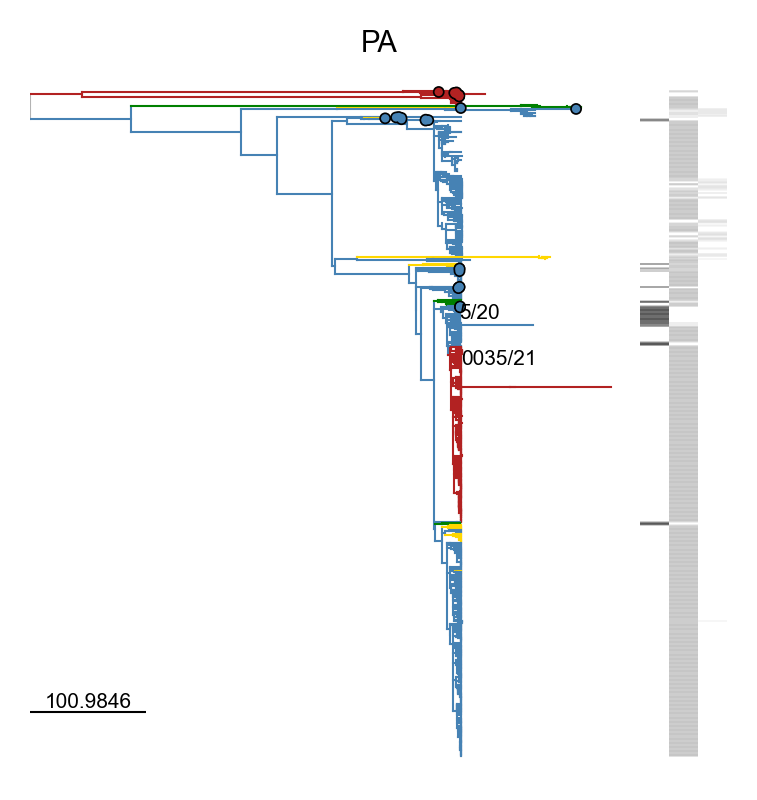

In [120]:
seg = 'PA'

df = pd.read_csv(f'./data/02_h5n1_blast/date_{seg}.txt', index_col=0)

df['time3'] = df.Date.astype(float)


tree = dendropy.Tree.get(path=f"./data/02_h5n1_blast/time_region_{seg}/annotated_tree.nexus", 
                         schema='nexus', 
                         extract_comment_metadata=True, 
                         preserve_underscores=True, 
                         suppress_internal_node_taxa=False) 

# node_with_zero_branch = []
# for node in tree.preorder_node_iter():
#     if node.edge_length == 0:
#         node_with_zero_branch.append(node)

# tree.prune_nodes(node_with_zero_branch, update_bipartitions=False, prune_leaves_without_taxa=True)

treeString = tree.as_string(
    schema='newick',
    suppress_rooting=False,
    suppress_internal_node_labels=False,
    suppress_internal_taxon_labels=True,
    suppress_item_comments=True,
    suppress_annotations=False, 
    annotations_as_nhx=False
)

ll = bt.loadNewick(StringIO(treeString))

print(len(ll.getExternal()))

subtype_color = {'H5N1': 'black', 'H5N8': 'steelblue'}
region_color = {'Europe': 'steelblue', 'North America': 'firebrick', 'Asia': 'gold', 'Africa': 'green'}

def branch_color(k):
    c = region_color.get(k.traits['Region'])
    if c:
        return c
    else:
        return 'black'


def tip_color2(k):
    try:
        subtype = isl2subtype.get(k.name)
        # subtype = df.loc[k.name, 'Subtype']
    except:
        subtype = 'H5N1'
    if not isinstance(subtype, str):
        subtype = subtype[0]

    region = k.traits['Region']

    if subtype == 'H5N1':
        return 'black'
    if subtype == 'H5N8':
        return 'gold'
    if region in ['Europe', 'Asia', 'Africa'] and subtype not in ['H5N1', 'H5N8']:
        return 'steelblue'
    if region == 'North America' and subtype not in ['H5N1', 'H5N8']:
        return 'firebrick'

def target_set(k):
    c1 = k.is_leaf()
    if not c1:
        return False
    c2 = isl2subtype.get(k.name)
    if not c2:  
        c2 = 'H5N1'
    if not isinstance(c2, str):
        c2 = c2[0]
    c2 = c2 != 'H5N1'
    return c1 and c2


fig, ax = plt.subplots(figsize=(3,3), dpi=300)

ll.plotTree(ax=ax, width=.5, colour=branch_color)
ll.plotPoints(ax=ax, size=4, colour=tip_color2, target=target_set, marker='o')

treeHeight = ll.treeHeight
ax.hlines(y=100, xmin=0, xmax=treeHeight/5, lw=.5, color='k')
ax.text((0+treeHeight/5)/2, 100, f"{treeHeight/5:.4f}", fontdict={'fontsize': 5, 'va': 'bottom', 'ha': 'center'})


for leaf in ll.getExternal():

    if leaf.name == early_strain_in_USA:
        ax.text(leaf.x+0.001, leaf.y, '0035/21', fontdict={'fontsize':5, 'va': 'center', 'ha': 'left'})
    elif leaf.name == early_strain_in_Europe:
        ax.text(leaf.x+0.001, leaf.y, '5/20', fontdict={'fontsize':5, 'va': 'center', 'ha': 'left'})

    try:
        date2 = df.loc[leaf.name, 'time3']

        if round(date2) == 2021:
            c = 'black'
            left = ll.treeHeight * 1.05
        elif round(date2) == 2022:
            c = 'darkgray'
            left = ll.treeHeight * 1.1
        elif round(date2) == 2023:
            c = 'lightgray'
            left = ll.treeHeight * 1.15
        else:
            continue
    except:
        continue


    ax.hlines(leaf.y, xmin=left, xmax=left + treeHeight/20, color=c, lw=.1, alpha=.9, ls='-')


ax.set(xlim=(0, ll.treeHeight*1.2), ylim=(-30, ll.ySpan+30), xticks=[], yticks=[])
ax.set_title(seg, fontsize=7)
ax.margins(y=.2)
[ax.spines[loc].set_visible(False) for loc in ax.spines]

plt.show()

In [123]:
def plot_segment_tree(seg, ax):
    
    # df = pd.read_csv(f'./data/01_h5_2344b_after2019/dfs/{seg}23.csv', index_col=0)
    df = pd.read_csv(f'./data/02_h5n1_blast/date_{seg}.txt', index_col=0)

    df['time3'] = df.Date.astype(float)
    # try:
    #     df['time2'] = pd.to_datetime(df.Time).map(lambda x: x.year if x.month <=6 else x.year + .5)
    #     df['time3'] = df.Time.map(lambda x: bt.decimalDate(x, fmt='%Y/%m/%d'))
    # except:
    #     df['time2'] = pd.to_datetime(df.Time, format='%Y_%m_%d').map(lambda x: x.year if x.month <=6 else x.year + .5)
    #     df['time3'] = df.Time.map(lambda x: bt.decimalDate(x, fmt='%Y_%m_%d'))

    tree = dendropy.Tree.get(path=f"./data/02_h5n1_blast/region_{seg}/annotated_tree.nexus", 
                             schema='nexus', 
                             extract_comment_metadata=True, 
                             preserve_underscores=True, 
                             suppress_internal_node_taxa=False) 

    treeString = tree.as_string(
        schema='newick',
        suppress_rooting=False,
        suppress_internal_node_labels=False,
        suppress_internal_taxon_labels=True,
        suppress_item_comments=True,
        suppress_annotations=False, 
        annotations_as_nhx=False
    )

    ll = bt.loadNewick(StringIO(treeString))

    subtype_color = {'H5N1': 'black', 'H5N8': 'steelblue'}
    region_color = {'Europe': 'steelblue', 'North America': 'firebrick', 'Asia': 'gold', 'Africa': 'green'}

    def branch_color(k):
        c = region_color.get(k.traits['Region'])
        if c:
            return c
        else:
            return 'black'


    def tip_color2(k):
        try:
            subtype = isl2subtype.get(k.name)
            # subtype = df.loc[k.name, 'Subtype']
        except:
            subtype = 'H5N1'
        if not isinstance(subtype, str):
            subtype = subtype[0]
        
        region = k.traits['Region']
        
        if subtype == 'H5N1':
            return 'black'
        if subtype == 'H5N8':
            return 'gold'
        if region in ['Europe', 'Asia', 'Africa'] and subtype not in ['H5N1', 'H5N8']:
            return 'steelblue'
        if region == 'North America' and subtype not in ['H5N1', 'H5N8']:
            return 'firebrick'

    def target_set(k):
        c1 = k.is_leaf()
        if not c1:
            return False
        c2 = isl2subtype.get(k.name)
        if not c2:  
            c2 = 'H5N1'
        if not isinstance(c2, str):
            c2 = c2[0]
        c2 = c2 != 'H5N1'
        return c1 and c2

    ll.plotTree(ax=ax, width=.5, colour=branch_color)
    ll.plotPoints(ax=ax, size=4, colour=tip_color2, target=target_set, marker='o')
    
    treeHeight = ll.treeHeight
    ax.hlines(y=100, xmin=0, xmax=treeHeight/5, lw=.5, color='k')
    ax.text((0+treeHeight/5)/2, 100, f"{treeHeight/5:.4f}", fontdict={'fontsize': 5, 'va': 'bottom', 'ha': 'center'})


    for leaf in ll.getExternal():
        
        if leaf.name == early_strain_in_USA:
            ax.text(leaf.x+0.001, leaf.y, '0035/21', fontdict={'fontsize':5, 'va': 'center', 'ha': 'left'})
        elif leaf.name == early_strain_in_Europe:
            ax.text(leaf.x+0.001, leaf.y, '5/20', fontdict={'fontsize':5, 'va': 'center', 'ha': 'left'})
        
        try:
            date2 = df.loc[leaf.name, 'time3']
            
            if round(date2) == 2021:
                c = 'black'
                left = ll.treeHeight * 1.05
            elif round(date2) == 2022:
                c = 'darkgray'
                left = ll.treeHeight * 1.1
            elif round(date2) == 2023:
                c = 'lightgray'
                left = ll.treeHeight * 1.15
            else:
                continue
        except:
            continue
        

        # ax.hlines(leaf.y, xmin=left, xmax=left + treeHeight/20, color=c, lw=.1, alpha=.9, ls='-')


    ax.set(xlim=(0, ll.treeHeight*1.2), ylim=(-30, ll.ySpan+30), xticks=[], yticks=[])
    ax.set_title(seg, fontsize=7)
    ax.margins(y=.2)
    [ax.spines[loc].set_visible(False) for loc in ax.spines]



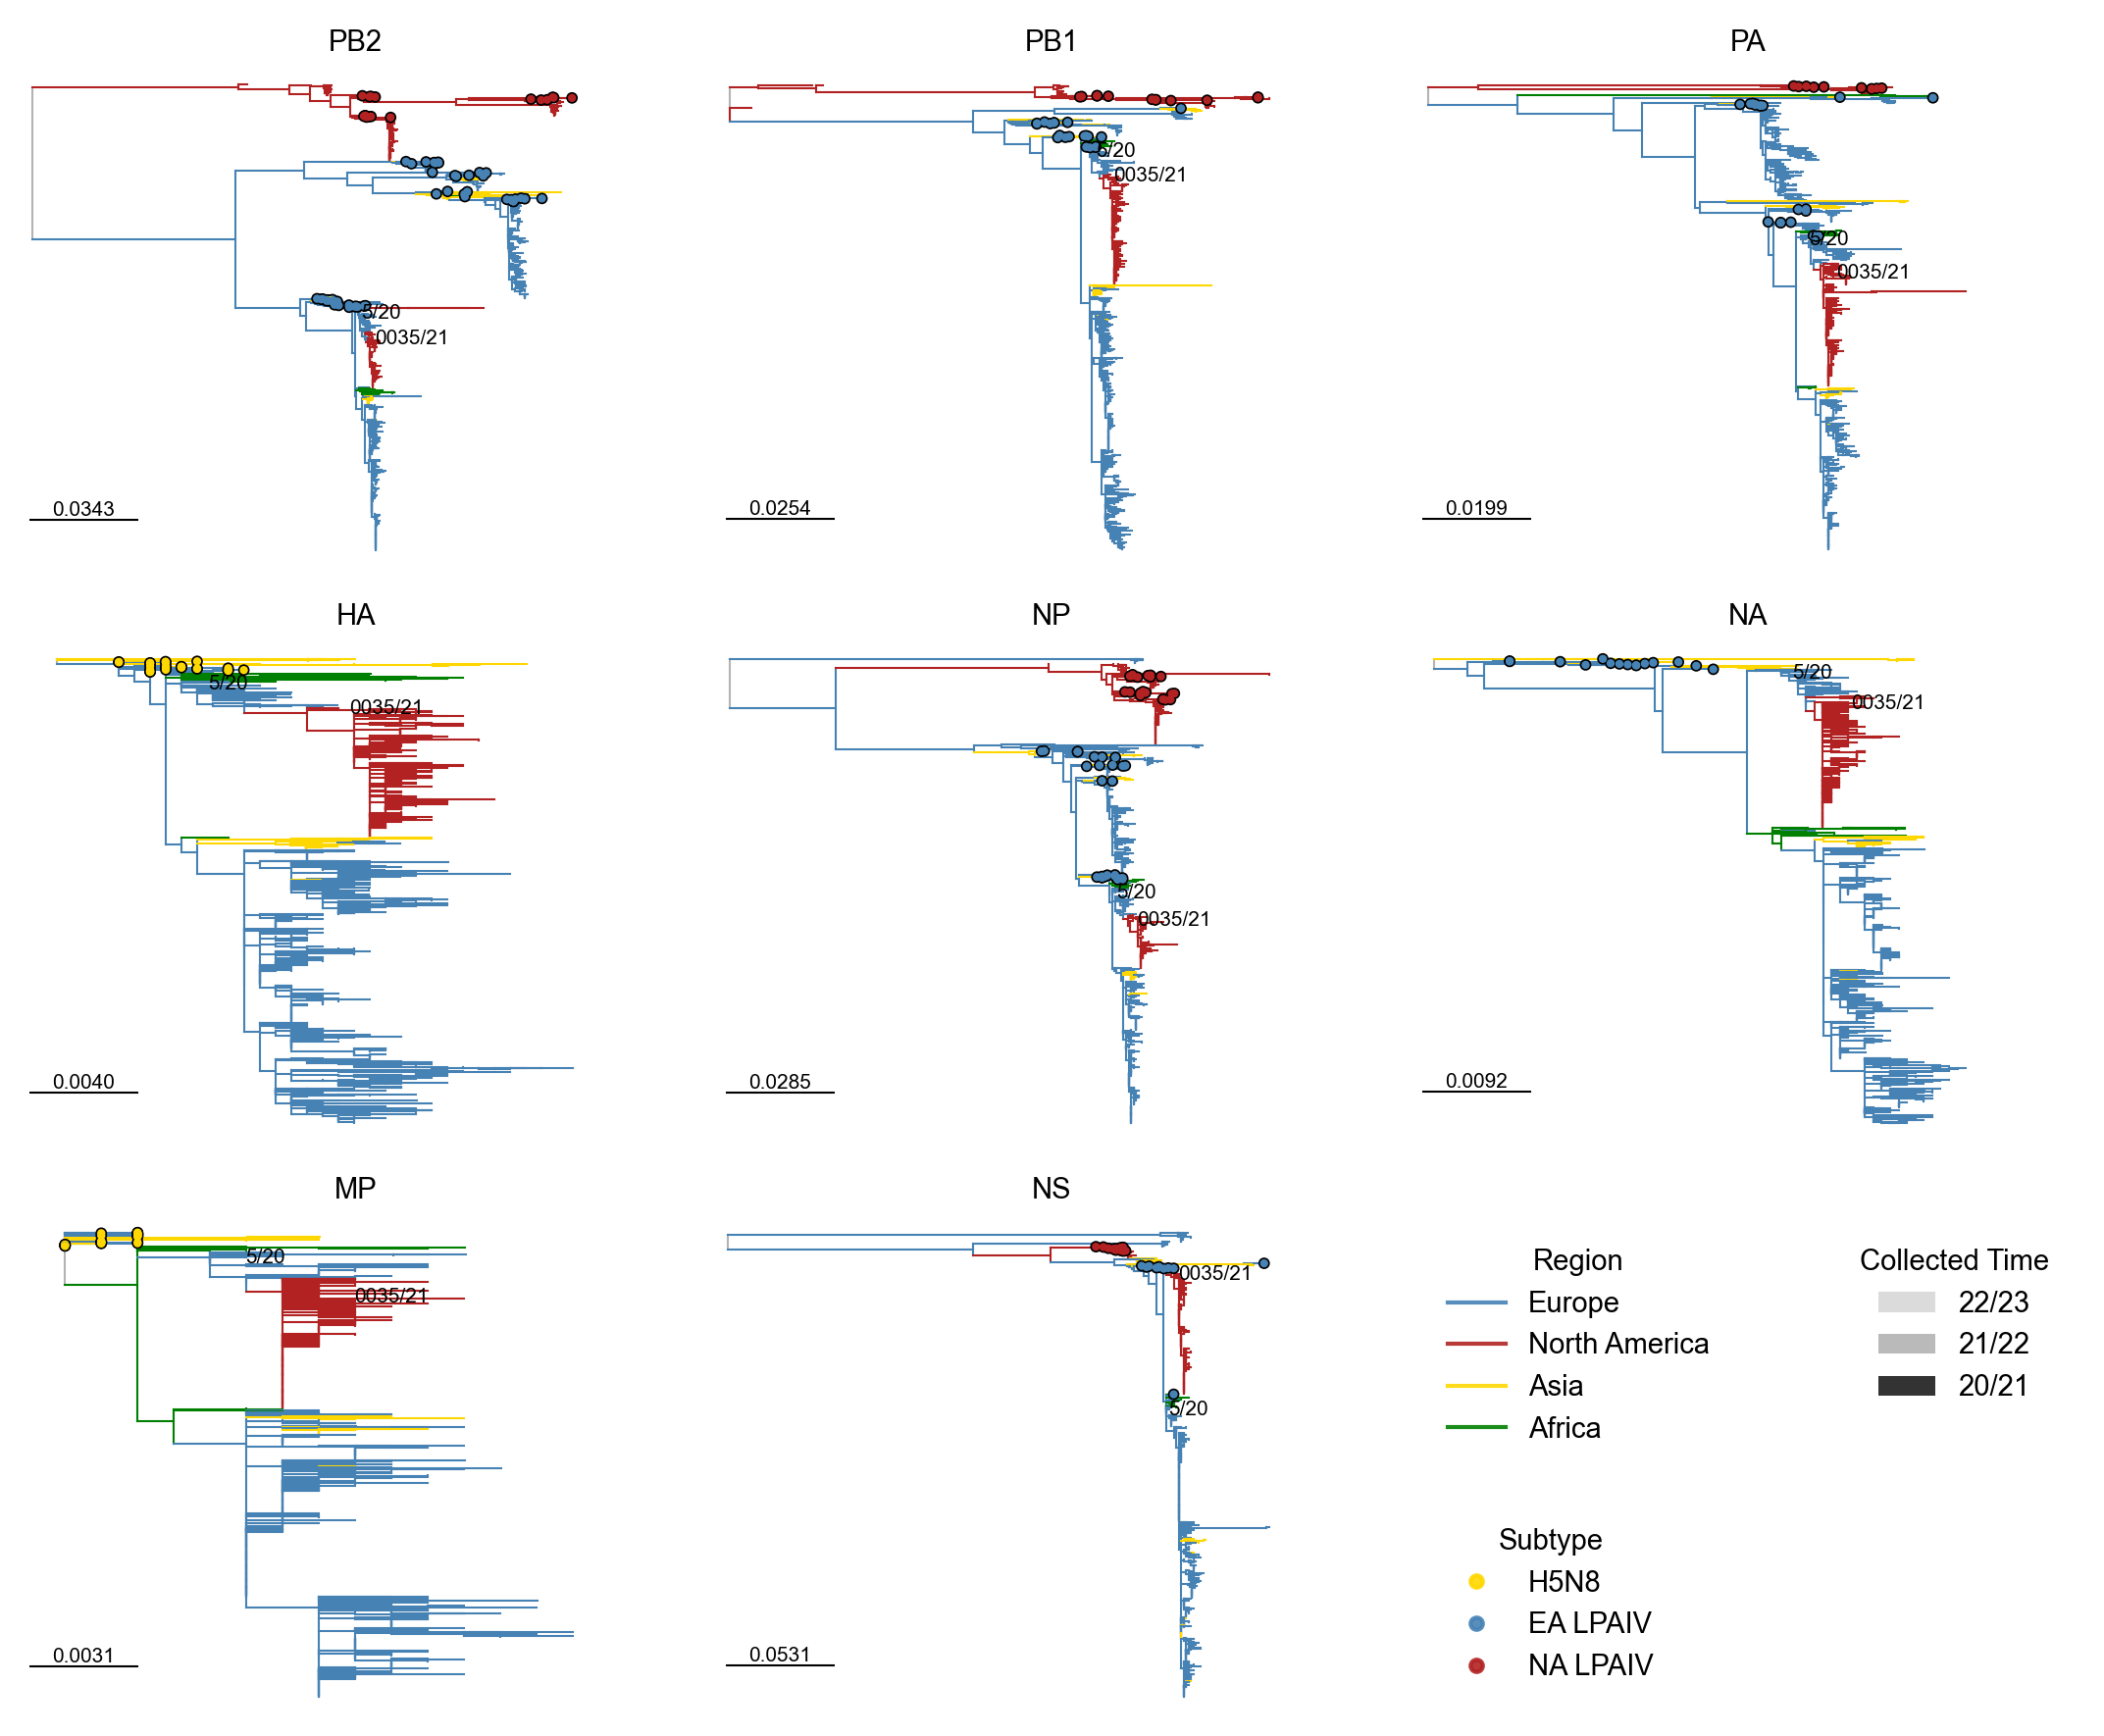

In [124]:
fig, axs = plt.subplots(3, 3, figsize=(7.25, 6), dpi=300)
axs = np.ravel(axs)

for ax, seg in zip(axs, ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']):
    plot_segment_tree(seg, ax)


ax = axs[-1]

handles = []
for k, v in region_color.items():
    handles.append(Line2D([0], [0], marker='o', markerfacecolor=v, lw=1, label=k, alpha=.9, markersize=0, color=v))
ax.legend(handles=handles, frameon=False, fontsize=7, loc='upper left', title='Region', title_fontsize=7) 
    
handles = []
for k, v in zip(['H5N8', 'EA LPAIV','NA LPAIV'], ['gold', 'steelblue', 'firebrick']):
    handles.append(Line2D([0], [0], marker='o', markerfacecolor=v, lw=0, label=k, alpha=.9, markersize=3, color=v))
leg = Legend(ax, handles=handles, labels=['H5N8', 'EA LPAIV','NA LPAIV'], frameon=False, fontsize=7, loc='lower left', title='Subtype', title_fontsize=7)
ax.add_artist(leg)

handles = []
for i, (a, b) in enumerate(zip(['22/23', '21/22', '20/21'],['lightgray','darkgray','black'])):
    handles.append(mpatches.Patch(facecolor=b, label=a, alpha=.8, linewidth=0))
leg = Legend(ax, handles=handles, labels=['22/23', '21/22', '20/21'], frameon=False, fontsize=7, loc='upper right', title='Collected Time', title_fontsize=7)
ax.add_artist(leg)

ax.set(xticks=[], yticks=[])      
[ax.spines[loc].set_visible(False) for loc in ax.spines]

plt.tight_layout()

# plt.savefig('./results/Fig3.pdf')
plt.show()
